In [1]:
%matplotlib widget

import numpy as np

from tuw_education_notebooks.view_bayes_flood import view_bayes_flood
from tuw_education_notebooks.calc_priors import sig0_dc, calc_priors, plot_posteriors

import ipywidgets as widgets
from eomaps import Maps

# Backscatter

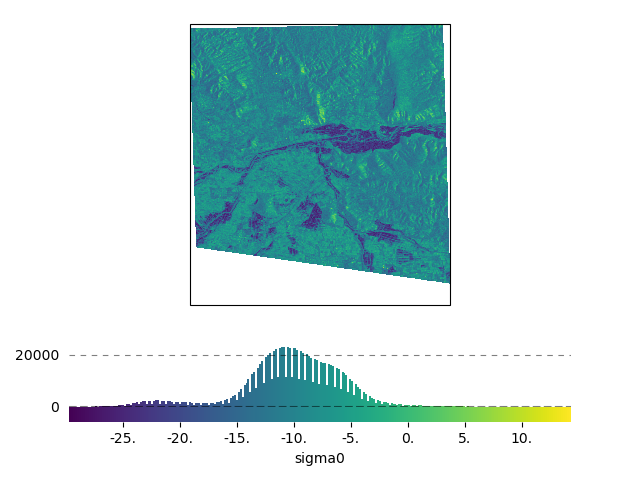

In [2]:
m = Maps()
m.set_data(data=sig0_dc, x="x", y="y", parameter="SIG0", crs=sig0_dc.spatial_ref.crs_wkt)
m.plot_map()
m.add_colorbar(label="sigma0")
m.show()

# Priors

In [3]:
pixel = widgets.IntSlider(value=0, min=0, max=sig0_dc.SIG0.size)
pixel

IntSlider(value=0, max=1209000)

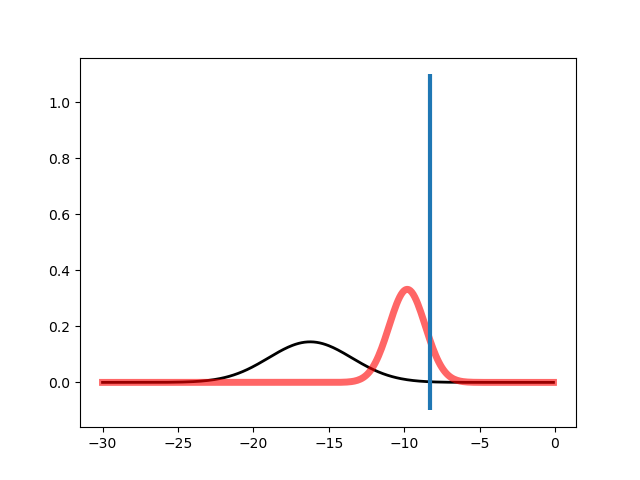

In [4]:
water_prior, land_prior = calc_priors(pixel.value, x = [-30, 0], plot=True)

# Posteriors

In [5]:
def calc_posteriors(water_prior, land_prior):
    evidence = (water_prior * 0.5) + (land_prior * 0.5)
    return (water_prior * 0.5) / evidence,  (land_prior * 0.5) / evidence

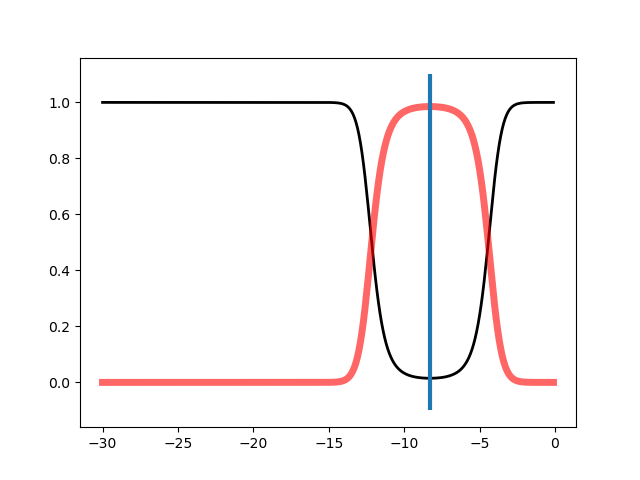

In [6]:
f_post_prob, nf_post_prob = calc_posteriors(water_prior, land_prior)
plot_posteriors(pixel.value, f_post_prob, nf_post_prob, x=[-30, 0])

# Flood Classification

In [7]:
def bayesian_flood_decision(id, sig0_dc):
    f_post_prob, nf_post_prob = calc_posteriors(*calc_priors(id,  sig0_dc))
    return np.greater(nf_post_prob, f_post_prob)

In [8]:
sig0 = sig0_dc.SIG0.where(sig0_dc.id==pixel.value, drop=True)
sig0

<xarray.DataArray 'SIG0' (y: 1, x: 1)> Size: 8B
array([[-8.3]])
Coordinates:
  * x        (x) float64 8B 5.661e+06
  * y        (y) float64 8B 6.42e+05
Attributes: (12/30)
    abs_orbit_number:       20802
    AREA_OR_POINT:          Area
    border_noise_removed:   True
    creation_date:          2021-07-19 19:54:09
    creator:                gfm_ops
    dem_source:             /eodc/private/jrc_gfm/gfm_scratch/copdem/CopDEM30...
    ...                     ...
    worker_git_tag:         from v1.0.0 to v1.1.0
    worker_name:            s1-sigma
    wrapper_git_commit:     none
    wrapper_git_tag:        v1.0.0
    wrapper_name:           gfm-sigma-offline
    grid_mapping:           spatial_ref

In [9]:
bayesian_flood_decision(pixel.value, sig0)

array([ True])

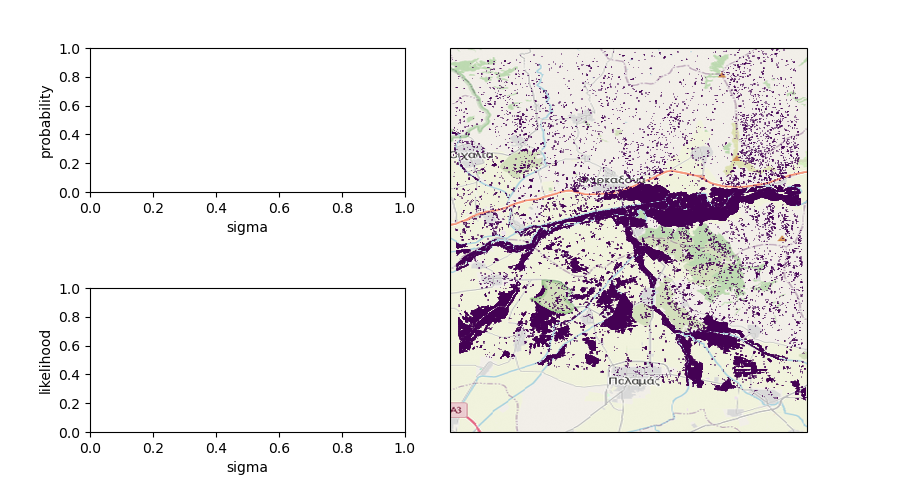

In [10]:
view_bayes_flood(sig0_dc, calc_posteriors, bayesian_flood_decision)